# Project Goals

### 1) Find drivers key drivers for churn
- Starting with electric checking
- Second with fiber optics
- Third senior citizen
- Fourth with dependents

### 2) Create a ML Model to predict churn using classification

In [1]:
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

import env
import acquireTelco
import prepTelco

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import graphviz
from graphviz import Graph

In [ ]:
# Here we take from our sql server, telco churn to acquire our data

In [2]:
telco_churn = acquireTelco.get_telco_data()
telco_df = telco_churn.copy()

In [93]:
# Prep Telco has both my clean fuction and split function
# We drop any duplicates need, change total charges to float type and encode all the variables needed to be encoded
# We drop any extra data (payment, internet, contract type ID's) since we need only customer ID
# Split the data 55, 25, 20 for train, validate, test

In [3]:
telco_df1 = prepTelco.clean_telco(telco_df)

## We see here the amount of churn within this data set

In [4]:
pd.crosstab(telco_df1['churn'], telco_df1['churn_Yes'])

churn_Yes,0,1
churn,,
No,5174,0
Yes,0,1869


In [6]:
train, validate, test = prepTelco.prep_telco(telco_df, 'churn')

# Question 1: 

### Is electric checking a large cause for churn?

In [86]:
pd.crosstab(telco_churn['churn'], telco_churn['payment_type'])

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
churn,,,,
No,1286,1290,1294,1304
Yes,258,232,1071,308


<AxesSubplot:title={'center':'Payment Type and their Churn Rate'}, xlabel='payment_type', ylabel='has_churn'>

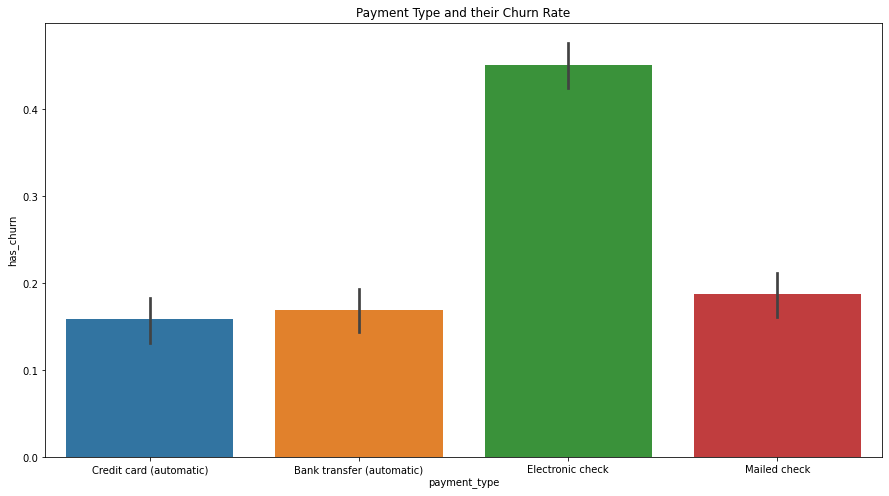

In [74]:
plt.figure(figsize=(15,8))
plt.title('Payment Type and their Churn Rate')
sns.barplot(x = 'payment_type', y = 'has_churn', data = train)

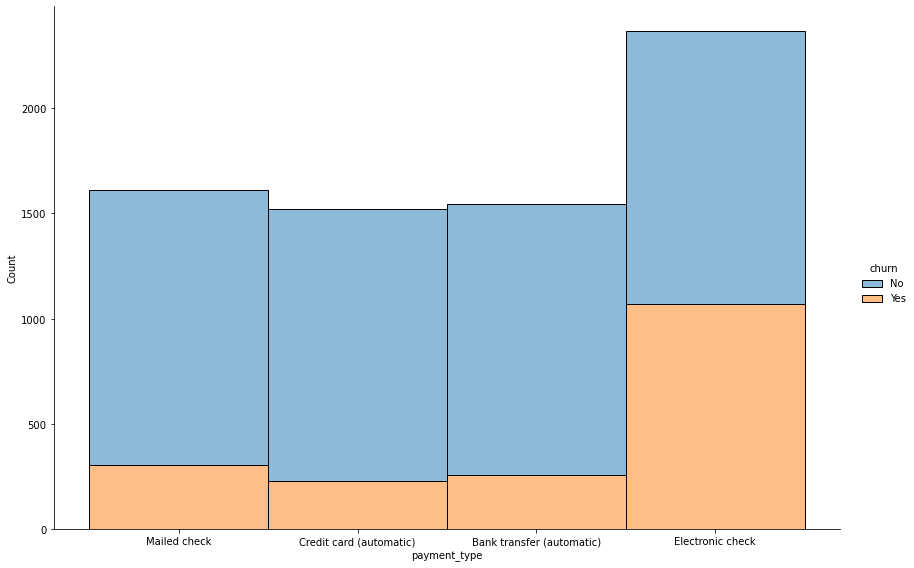

In [85]:
sns.displot(x = 'payment_type', data = telco_churn, hue = 'churn', alpha = 0.5, multiple = 'stack',
            height=8, aspect=12/8)

In [76]:
observed = pd.crosstab(train['payment_type_Electronic check'], train.has_churn)

In [14]:
chi, p, degrf, expected = stats.chi2_contingency(observed)

In [87]:
print('Observed')
print(observed)
print("--------------------------------------")
print('--------------------------------------\nExpected')
print(expected)
print("--------------------------------------")
print('---\n')
print(f'chi^2 = {chi:.4f}')
print(f'p     = {p:.4f}')

Observed
has_churn                         0    1
payment_type_Electronic check           
0                              2172  451
1                               725  595
--------------------------------------
--------------------------------------
Expected
[[2030.76540705  733.23459295]
 [ 866.23459295  312.76540705]]
--------------------------------------
---

chi^2 = 100.5470
p     = 0.0000


#### Answer: There is a relationship between eletric checking and churn!

# Question 2

#### Is internet internet service type(Fiber Optic) a cause for churn?

<AxesSubplot:title={'center':'Internet Service Type and their Churn Rates'}, xlabel='internet_service_type', ylabel='has_churn'>

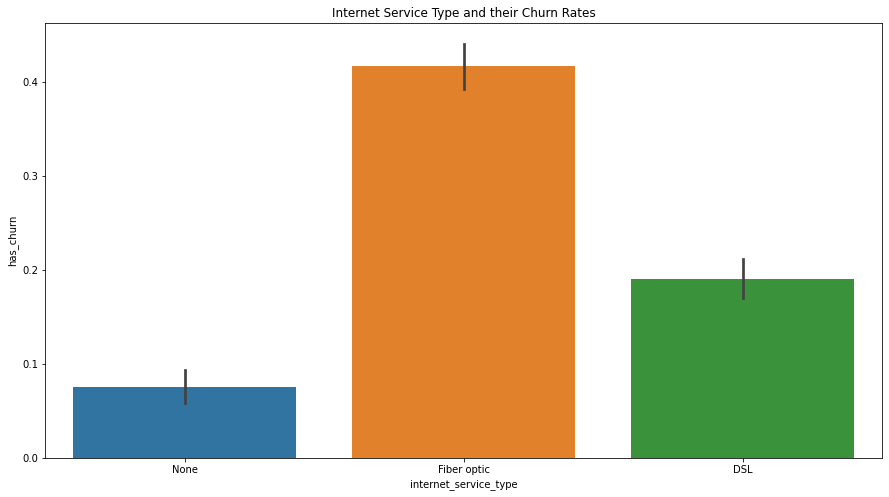

In [79]:
plt.figure(figsize=(15,8))
plt.title('Internet Service Type and their Churn Rates')
sns.barplot(x = 'internet_service_type', y = 'has_churn', data = train)

In [19]:
observed = pd.crosstab(train['internet_service_type_Fiber optic'], train.has_churn)
chi, p, degrf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed)
print("--------------------------------------")
print('---\nExpected')
print(expected)
print("--------------------------------------")
print('---\n')
print(f'chi^2 = {chi:.4f}')
print(f'p     = {p:.4f}')

Observed
has_churn                             0    1
internet_service_type_Fiber optic           
0                                  1881  322
1                                  1016  724
--------------------------------------
---
Expected
[[1618.58762364  584.41237636]
 [1278.41237636  461.58762364]]
--------------------------------------
---

chi^2 = 362.0332
p     = 0.0000


#### Answer: There is a relationship between service type fiber optic and churn!

# Question 3:

#### Is being a senior citizen effect churn?

<AxesSubplot:xlabel='senior_citizen', ylabel='has_churn'>

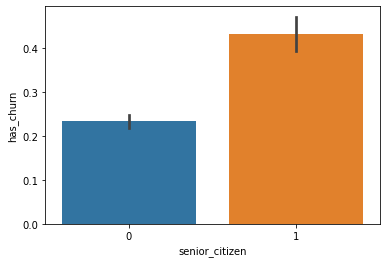

In [23]:
sns.barplot(x = 'senior_citizen', y = 'has_churn', data = train)

In [24]:
observed = pd.crosstab(train['senior_citizen'], train.has_churn)
chi, p, degrf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed)
print("--------------------------------------")
print('---\nExpected')
print(expected)
print("--------------------------------------")
print('---\n')
print(f'chi^2 = {chi:.4f}')
print(f'p     = {p:.4f}')

Observed
has_churn          0    1
senior_citizen           
0               2533  770
1                364  276
--------------------------------------
---
Expected
[[2426.77935582  876.22064418]
 [ 470.22064418  169.77935582]]
--------------------------------------
---

chi^2 = 106.9624
p     = 0.0000


#### Answer: There is a relationship between senior citizen and churn

# Question 4:

#### Is having an dependent effect churn?

<AxesSubplot:xlabel='has_dependent', ylabel='has_churn'>

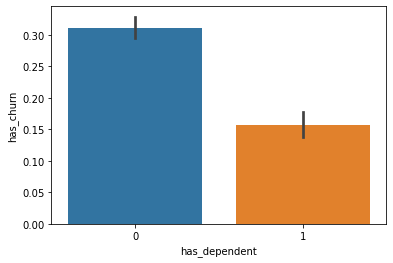

In [26]:
sns.barplot(x = 'has_dependent', y = 'has_churn', data = train)

In [27]:
observed = pd.crosstab(train['has_dependent'], train.has_churn)
chi, p, degrf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed)
print("--------------------------------------")
print('---\nExpected')
print(expected)
print("--------------------------------------")
print('---\n')
print(f'chi^2 = {chi:.4f}')
print(f'p     = {p:.4f}')

Observed
has_churn         0    1
has_dependent           
0              1903  861
1               994  185
--------------------------------------
---
Expected
[[2030.76540705  733.23459295]
 [ 866.23459295  312.76540705]]
--------------------------------------
---

chi^2 = 100.5470
p     = 0.0000


Answer: There is a relationship between having a dependent and churn!

# Decisioin Tree Model Creation

In [28]:
train['baseline'] = 0

validate['baseline'] = 0

test['baseline'] = 0

In [29]:
baseline_accuracy = (train.has_churn == train.baseline).mean()
print(f'baseline train accuracy: {baseline_accuracy:.2%}')

baseline_accuracy = (validate.has_churn == validate.baseline).mean()
print(f'baseline validate accuracy: {baseline_accuracy:.2%}')

baseline_accuracy = (test.has_churn == test.baseline).mean()
print(f'baseline test accuracy: {baseline_accuracy:.2%}')

baseline train accuracy: 73.47%
baseline validate accuracy: 73.45%
baseline test accuracy: 73.46%


In [89]:
# First model test using decision tree
# Second Random Forest
# KNN

In [31]:
X_train = train.drop(columns = ['customer_id','gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security',
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
                              'paperless_billing', 'churn', 'contract_type', 'internet_service_type', 'payment_type',
                              'has_churn', 'baseline'])
y_train = train.has_churn


X_validate = validate.drop(columns = ['customer_id','gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security',
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
                              'paperless_billing', 'churn', 'contract_type', 'internet_service_type', 'payment_type',
                              'has_churn', 'baseline'])
y_validate = validate.has_churn

X_test = test.drop(columns=['customer_id','gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security',
                              'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
                              'paperless_billing', 'churn', 'contract_type', 'internet_service_type', 'payment_type',
                              'has_churn', 'baseline'])
y_test = test.has_churn

In [32]:
clf = DecisionTreeClassifier(max_depth=3, random_state= 123)

clf = clf.fit(X_train, y_train)

In [33]:
clf2 = DecisionTreeClassifier(max_depth=5, random_state= 123)

clf2 = clf2.fit(X_train, y_train)

In [34]:
y_pred = clf.predict(X_train)

In [35]:
y_pred2 = clf2.predict(X_train)

In [36]:
y_pred_proba = clf.predict_proba(X_train)

In [37]:
y_pred_proba2 = clf2.predict_proba(X_train)

In [42]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2897
           1       0.71      0.36      0.48      1046

    accuracy                           0.79      3943
   macro avg       0.76      0.65      0.67      3943
weighted avg       0.78      0.79      0.77      3943



In [43]:
print(classification_report(y_train, y_pred2))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2897
           1       0.63      0.60      0.62      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.74      0.74      3943
weighted avg       0.80      0.80      0.80      3943



In [38]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


In [39]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf2.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


# Random Forest Model Creation

In [44]:
ranf = RandomForestClassifier(max_depth=10, min_samples_leaf=1, random_state= 123)
ranf = ranf.fit(X_train, y_train)

In [45]:
ranf2 = RandomForestClassifier(max_depth=5, min_samples_leaf=3, random_state= 123)
ranf2 = ranf2.fit(X_train, y_train)

In [46]:
y_pred = ranf.predict(X_train)

y_pred2 = ranf2.predict(X_train)

In [47]:
y_pred_proba = ranf.predict_proba(X_train)

y_pred_proba2 = ranf2.predict_proba(X_train)

In [50]:
print("Random Forest Model #1")
print("---------------------------------------------------------")
print("---------------------------------------------------------\n")
print(confusion_matrix(y_train, y_pred))

print("---------------------------------------------------------")
print("---------------------------------------------------------\n")
print(classification_report(y_train, y_pred))


print("\n\nRandom Forest Model #2")
print("---------------------------------------------------------")
print("---------------------------------------------------------\n")
print(confusion_matrix(y_train, y_pred2))

print("---------------------------------------------------------")
print("---------------------------------------------------------\n")
print(classification_report(y_train, y_pred2))

Random Forest Model #1
---------------------------------------------------------
---------------------------------------------------------

[[2768  129]
 [ 303  743]]
---------------------------------------------------------
---------------------------------------------------------

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2897
           1       0.85      0.71      0.77      1046

    accuracy                           0.89      3943
   macro avg       0.88      0.83      0.85      3943
weighted avg       0.89      0.89      0.89      3943



Random Forest Model #2
---------------------------------------------------------
---------------------------------------------------------

[[2725  172]
 [ 613  433]]
---------------------------------------------------------
---------------------------------------------------------

              precision    recall  f1-score   support

           0       0.82      0.94      0.87     

In [48]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(ranf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.89


In [49]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(ranf2.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.80


# KNN Model Creation

In [51]:
knn1 = KNeighborsClassifier()

knn1 = knn1.fit(X_train, y_train)


knn2 = KNeighborsClassifier(3)

knn2 = knn2.fit(X_train, y_train)

In [52]:
y_pred = knn1.predict(X_train)

y_pred2 = knn2.predict(X_train)

In [54]:
print("KNN Model #1")
print("---------------------------------------------------------")
print("---------------------------------------------------------\n")
print(confusion_matrix(y_train, y_pred))

print("---------------------------------------------------------")
print("---------------------------------------------------------\n")
print(classification_report(y_train, y_pred))


print("\n\nKNN Model #2")
print("---------------------------------------------------------")
print("---------------------------------------------------------\n")
print(confusion_matrix(y_train, y_pred2))

print("---------------------------------------------------------")
print("---------------------------------------------------------\n")
print(classification_report(y_train, y_pred2))

KNN Model #1
---------------------------------------------------------
---------------------------------------------------------

[[2685  212]
 [ 441  605]]
---------------------------------------------------------
---------------------------------------------------------

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      2897
           1       0.74      0.58      0.65      1046

    accuracy                           0.83      3943
   macro avg       0.80      0.75      0.77      3943
weighted avg       0.83      0.83      0.83      3943



KNN Model #2
---------------------------------------------------------
---------------------------------------------------------

[[2691  206]
 [ 374  672]]
---------------------------------------------------------
---------------------------------------------------------

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2897
           1  

In [53]:
accuracy1 = knn1.score(X_train, y_train)
print("This is the accuracy: ", round(accuracy1, 3))


accuracy2 = knn2.score(X_train, y_train)
print("This is the accuracy: ", round(accuracy2, 3))

This is the accuracy:  0.834
This is the accuracy:  0.853


# Validation Testing

#### Decision Tree Validation

In [55]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf2.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.77


In [56]:
# Produce y_predictions that come from the X_validate
y_pred = clf2.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1242
           1       0.57      0.58      0.57       449

    accuracy                           0.77      1691
   macro avg       0.71      0.71      0.71      1691
weighted avg       0.77      0.77      0.77      1691



#### Rand Forest Validation

In [58]:
# Produce y_predictions that come from the X_validate
y_pred = ranf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1242
           1       0.66      0.50      0.57       449

    accuracy                           0.80      1691
   macro avg       0.74      0.70      0.72      1691
weighted avg       0.79      0.80      0.79      1691



In [90]:
print('Accuracy of random forest classifier on Validation set: {:.2f}'
     .format(ranf.score(X_validate, y_validate)))

Accuracy of random forest classifier on Validation set: 0.80


#### KNN Validation

In [60]:
# Produce y_predictions that come from the X_validate
y_pred = knn1.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1242
           1       0.56      0.47      0.51       449

    accuracy                           0.76      1691
   macro avg       0.69      0.67      0.67      1691
weighted avg       0.75      0.76      0.75      1691



In [91]:
print('Accuracy of KNN classifier on Validate set: {:.2f}'
     .format(knn1.score(X_validate, y_validate)))

Accuracy of KNN classifier on Validate set: 0.76


# Test Testing

In [92]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(ranf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.81


In [62]:
# Produce y_predictions that come from the X_test
y_pred = ranf.predict(X_test)

# Compare actual y values (from Test) to predicted y_values from the model run on X_test
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.67      0.55      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [63]:
print(ranf.feature_importances_)

[0.01756806 0.19445219 0.12545444 0.17101702 0.01931702 0.01532658
 0.01533921 0.00531239 0.00541106 0.01605719 0.01077373 0.02797329
 0.00749741 0.01831546 0.00791722 0.01415667 0.0072475  0.03355501
 0.0079612  0.01374514 0.0108079  0.0132009  0.02609897 0.02599399
 0.04625988 0.06471474 0.00691932 0.01194034 0.049468   0.01019818]


In [64]:
X_train.columns

Index(['senior_citizen', 'tenure', 'monthly_charges', 'total_charges',
       'is_male', 'has_partner', 'has_dependent', 'phone_service_Yes',
       'multiple_lines_No phone service', 'multiple_lines_Yes',
       'online_security_No internet service', 'online_security_Yes',
       'online_backup_No internet service', 'online_backup_Yes',
       'device_protection_No internet service', 'device_protection_Yes',
       'tech_support_No internet service', 'tech_support_Yes',
       'streaming_tv_No internet service', 'streaming_tv_Yes',
       'streaming_movies_No internet service', 'streaming_movies_Yes',
       'paperless_billing_Yes', 'contract_type_One year',
       'contract_type_Two year', 'internet_service_type_Fiber optic',
       'internet_service_type_None', 'payment_type_Credit card (automatic)',
       'payment_type_Electronic check', 'payment_type_Mailed check'],
      dtype='object')

# Key Takeaways

Starting with electric checking have a relatioship with churn, fiber optics have a relationship wiht churn, is being a senior citizen a cause for churn, is having a dependent a cause for churn?

During these tests we see that there a significant cause for churn with all these items based off statistical analysis tests/charts. When running through the algorithms to create the ML we find that random forest model is best suited for this job of finding churn, I'd say that with 80% accuracy that this random forest model will be able to detect churn with future unseen data.

# Recommendations

We see here that fiber optics and electric checking have a large cause of churn within this data set and my recommendation would be to further investigate the cause on these variables, we can also see through our ML using random forest we can use its 'feature_importance_' function to finder other ideal causes for churn by seeing there significance in finding other key churn values. We should create a team to investigate these high rates of churn detected by the model first starting with fiber optics and creating a new plan on handling churn as well as electric checking.

# Next Time

As stated before we can use the model also see what it decided what are key features in determeing what causes to churn, I would like for next time to further investage those variables!